In [1]:
import os
import struct
import random
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import pydot
import pydotplus
import graphviz
import scipy
import scipy.stats as stats
from scipy.stats import norm
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creation of truncated normal distribution between 0 and size

In [3]:
size = 500000
mean = int(size / 2)
std_dev = 60000
## Scypi.stats.truncnorm è di difficile uso
t_norm = stats.truncnorm(0, size)
## Meglio troncare la np.norm manualmente? Proviamo
norm = np.random.normal(loc=mean, scale=std_dev, size=size).astype(int)
np.set_printoptions(threshold=np.nan)
np.min(norm), np.max(norm)

(-39766, 523726)

In [4]:
norm = norm + abs(np.min(norm))

In [7]:
norm = np.sort(norm)

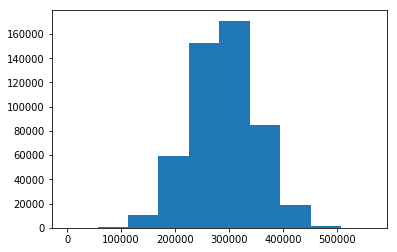

In [8]:
plt.hist(norm)
plt.show()

In [ ]:
## Traslazione normale effettuata.
## Calcolare ecdf della normale e metterla in un array
## Procedere alle operazioni come ne